# Assignment 2: Predictive Modelling of Stress in Reddit Posts

## Introduction

In recent years, online social platforms, such as Reddit, have become important spaces where individuals share personal experiences and seek advice. These informal digital environments provide large amounts of user-generated text that can offer insights about emotional distress. For instance, stress is a significant mental health concern that can affect an individual's emotional well-being, behavour and daily functioning. However, such text is typically unstructured, noisy and context-dependent, presenting challenges for automated analysis.

This project aims to develop the following three predictive models that detect stress signals from social media posts::
1. A logistic model using pre-computed linguistic features
2. A logistic model using TF-IDF representations
3. A tranformer-based model

By comparing these approaches, this study evaluates how different representations of language (linguistic features, statistical word representations and transformer-based contextual embeddings) influence performance and interpretability of stress detection.

## About Dreaddit

Dreaddit is a dataset of lengthy social media posts in five categories, each including stressful and non-stressful text and different ways of expressing stress.

In [1]:
# import data visualisation libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# load datasets
train_path = "data/dreaddit-train.csv"
test_path = "data/dreaddit-test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [3]:
train_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [4]:
print("Train shape:", train_df.shape)

Train shape: (2838, 116)


In [5]:
print(train_df.columns.tolist())

['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tentat', 'lex_liwc_certain', 'lex_liwc_differ', 'lex_liwc_

In [6]:
train_df.describe()

,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
count,2838.000000,2838.000000,2838.000000,2.838000e+03,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,...,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,13751.999295,0.524313,0.808972,1.518107e+09,18.262156,4.684272,85.996124,35.240941,40.948231,67.044249,...,1.088001,1.120099,1.000211,1.722759,1.536400,1.879385,0.843517,9.948555,5.448836,0.040740
std,17340.161897,0.499497,0.177038,1.552209e+07,79.419166,3.316435,32.334887,26.486189,31.587117,32.880644,...,0.117159,0.085227,0.006500,0.047835,0.102971,0.058932,0.174794,21.798032,2.535829,0.195490
min,4.000000,0.000000,0.428571,1.483274e+09,0.000000,-6.620000,5.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.485400,1.200000,1.561150,0.140000,0.000000,-1.918000,-1.000000
25%,926.250000,0.000000,0.600000,1.509698e+09,2.000000,2.464243,65.000000,12.410000,12.135000,41.070000,...,1.000000,1.000000,1.000000,1.691430,1.469745,1.841782,0.750000,2.000000,3.729973,-0.072222
50%,1891.500000,1.000000,0.800000,1.517066e+09,5.000000,4.321886,81.000000,29.420000,33.520000,80.710000,...,1.000000,1.142900,1.000000,1.721430,1.530295,1.878250,0.890000,5.000000,5.210000,0.044821
75%,25473.750000,1.000000,1.000000,1.530898e+09,10.000000,6.505657,101.000000,55.057500,69.320000,96.180000,...,1.142900,1.142900,1.000000,1.751760,1.596030,1.916243,1.000000,10.000000,6.855217,0.166667
max,55757.000000,1.000000,1.000000,1.542592e+09,1435.000000,24.074231,310.000000,99.000000,99.000000,99.000000,...,1.900000,1.500000,1.200000,2.007400,2.066670,2.158490,1.000000,416.000000,21.198919,1.000000


The train dataset contains 2838 Reddit posts for stress-related content. In addition to the raw text of each post, the dataset includes a range of pre-computed linguistic features such as Linguistic Inquiry and Word Count (LIWC) features, Dictionary of Affect in Language (DAL) scores, syntactic indices and sentiment. These features capture different aspects of language use, including emotional expression and psychological states.

The availability of these features enable both text-based modelling and interpretable feature-based analysis.

In [7]:
# stress label distribution
label_counts = train_df['label'].value_counts()
print(
    "Number of Stress labels:", label_counts[1],
    "\nNumber of Non-stress labels:", label_counts[0]
)

Number of Stress labels: 1488 
Number of Non-stress labels: 1350


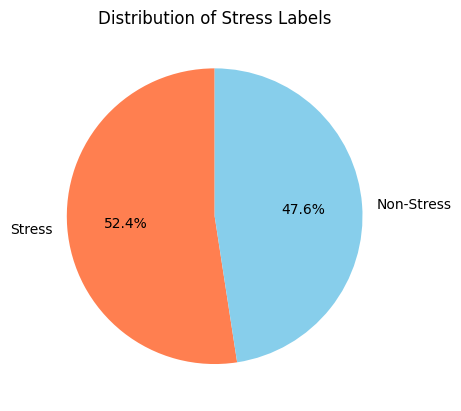

In [8]:
# pie chart of stress label distribution
plt.pie(train_df["label"].value_counts(normalize=True),
        autopct='%1.1f%%',
        labels=['Stress', 'Non-Stress'],
        colors=['coral', 'skyblue'],
        startangle=90)
plt.title('Distribution of Stress Labels')
plt.show()

The training dataset presents a near-balanced overall stress distribution, with 1488 stress labels and 1350 non-stress labels. This relatively balanced class distribution is beneficial for model training, as it reduces the risk of model bias towards predicting the dominant class.

A balanced dataset also allows us to use F1 score as a reliable evaluation metric. F1 score takes into account:
- missing a stressed post, and
- incorrectly labelling a non-stressed post as stressed.

Hence, F1 score provides a more meaningful measure of performance than accuracy.

However, only examining the overall distribution may hide underlying imbalances in the dataset.

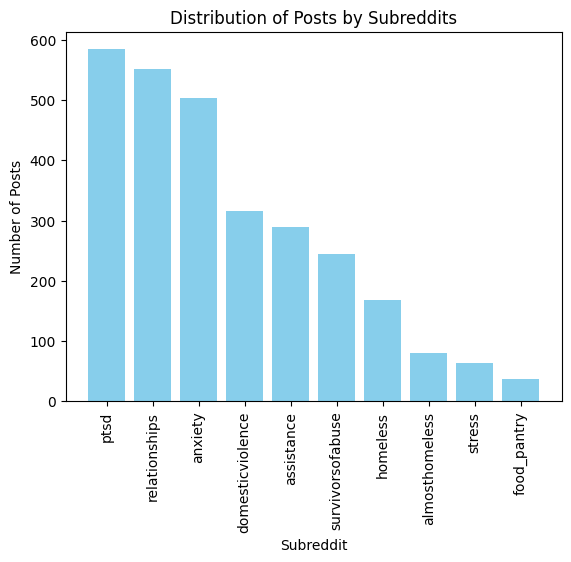

In [9]:
# histogram for subreddit distribution
subreddit_counts = train_df['subreddit'].value_counts()

plt.bar(subreddit_counts.index, subreddit_counts.values, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.title('Distribution of Posts by Subreddits')
plt.show()

The above histogram reveals that the number of posts varies significantly across different subreddits. This unequal representation may introduce bias in how the model interprets stress-related language across communities as the model learns frequently represented subreddits more strongly and may generalise poorly to those with fewer examples.

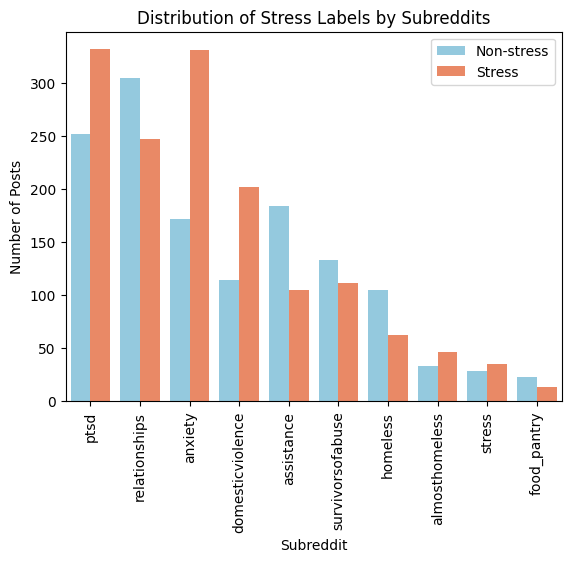

In [10]:
# plot for subreddit stress label distribution
sns.countplot(data=train_df,
              x='subreddit',
              hue='label',
              palette=['skyblue', 'coral'],
              order=subreddit_counts.index)
plt.xticks(rotation=90)
plt.title('Distribution of Stress Labels by Subreddits')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.legend(labels=['Non-stress', 'Stress'])
plt.show()

This plot further shows the proportion of 'Stress' vs 'Non-stress' labels within each subreddit. Notably, subreddits like 'Anxiety' and 'Domestic Violence' have a higher stress proportion while 'Relationships' and 'Assistance' has a higher non-stress proportion. Thus, there remains class imbalance within individual subreddits.

This necessitates an error analysis across communities when interpreting the models. Examining prediction mistakes by subreddit can help determine whether the models struggle with certain contexts of types of language.

In [11]:
# text length analysis
train_df["text"].str.split().str.len().describe()

count    2838.000000
mean       85.669838
std        32.292305
min         1.000000
25%        65.000000
50%        80.000000
75%       101.000000
max       310.000000
Name: text, dtype: float64

Reddit posts in the training dataset mostly range between 65 and 101 words. Based on this distribution, a maximum sequence length of 192 tokens is sufficient to cover majority of the posts, minimising truncation of important information while reducing computational cost and training time.

The average post length of 85 words also falls within the typical input limits of Transformer architectures. This allows the use of standard models such as BERT without requiring specialised handling for long text.

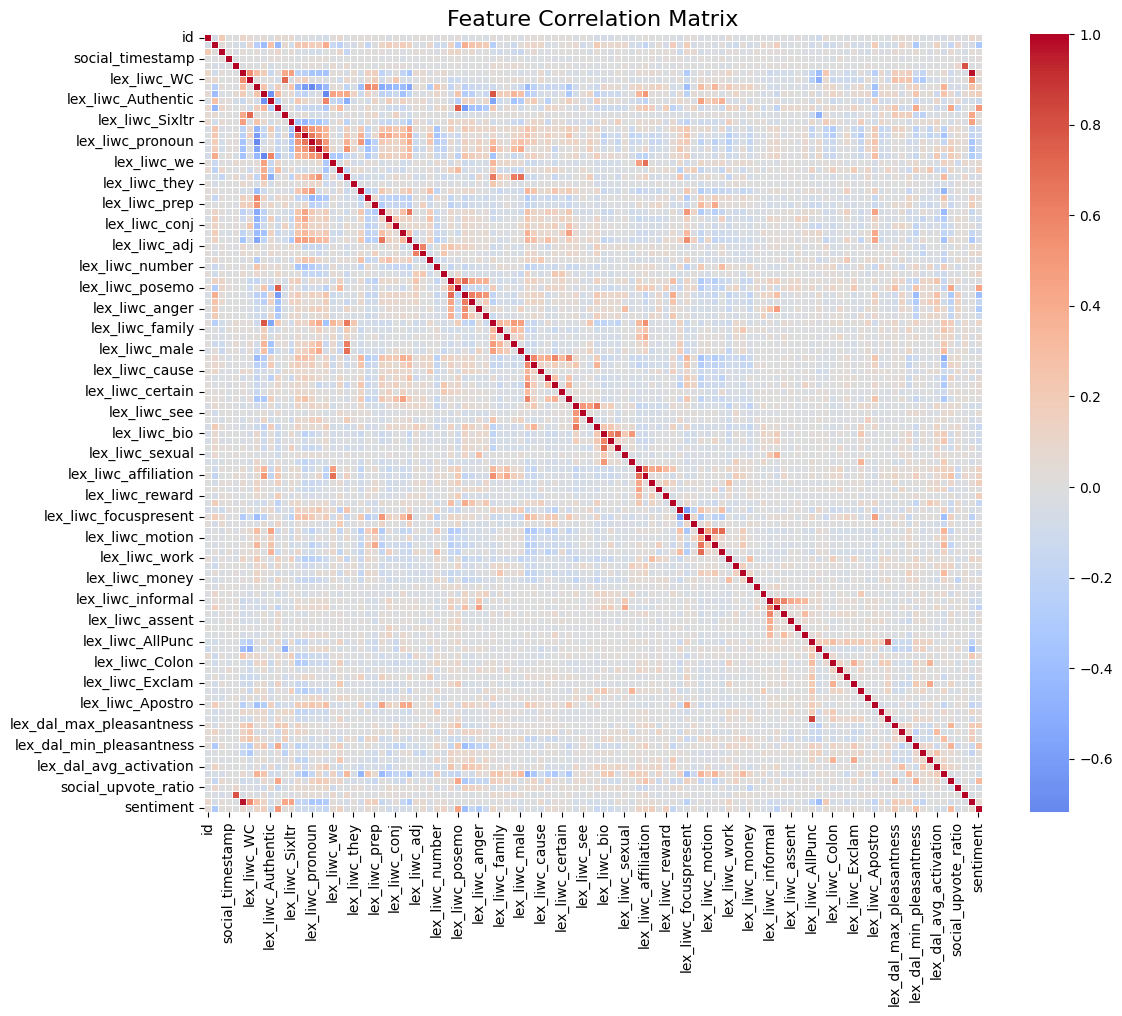

In [12]:
# select numerical columns
numerical_df = train_df.select_dtypes(include=[np.number])

# calculate correlation matrix
correlation_matrix = numerical_df.corr()

# plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

The correlation matrix reveals moderate correlations among several features. It might be meaningful to conduct Principal Component Analysis (PCA) to reduce dimensionality before applying a linear model.

## Model 1: Logistic Regression with Linguistic Features

The first approach utilises the pre-computed linguistic features available in the dataset. It extracts the linguistic, syntactical and sentiment features, totaling over 100 features, and uses them to train a Logistic Regression classifier.

In [13]:
# import scikit-learn libraries
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [14]:
# identify linguistic features: LIWC (lex_liwc_*), DAL (lex_dal_*), syntax_fk_grade and sentiment
feature_cols = [col for col in train_df.columns if col.startswith('lex_') or col.startswith('syntax_') or col.startswith('sentiment')]
print(f"Number of linguistic features found: {len(feature_cols)}")

X_train_lf = train_df[feature_cols]
y_train_lf = train_df['label']
    
X_test_lf = test_df[feature_cols]
y_test_lf = test_df['label']

Number of linguistic features found: 105


In [15]:
# pipeline to scale features and apply PCA
lf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lf_pipeline.fit(X_train_lf, y_train_lf)
    
pca_model = lf_pipeline.named_steps['pca']
n_components = pca_model.n_components_
print(f"\nPCA reduced features from {X_train_lf.shape[1]} to {n_components} components.")


PCA reduced features from 105 to 71 components.


The linguistic feature set initially comprised of 105 variables, capturing LIWC metrics, DAL scores, syntactic indices and sentiment. To address multicollinearity among these features, PCA was applied to reduce the dimensionality to 71 components while retaining 95% of the variance.

### Evaluation

In [16]:
preds_lf = lf_pipeline.predict(X_test_lf)

f1_lf = f1_score(y_test_lf, preds_lf)
print(f"Test F1 Score: {f1_lf:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_lf, preds_lf))

Test F1 Score: 0.7625

Confusion Matrix:
[[233 113]
 [ 72 297]]


The Logistic Regression model using linguistic features achieved an F1 score of 0.7625 on the test set. While linguistic features provide good interpretability, allowing us to trace prediction back to specific psycho-linguistic metrics, the moderate performance suggests that the computed features might not capture the full semantic meaning of stress expression compared to more advanced techniques.

It also yields a recall of 76.4% and precision of 67.3%, suggesting that the model is biased towards predicting stress.

### Analysis 1: Important Linguistic Features

In [17]:
# interpret PCA components for Logistic Regression
lf_model = lf_pipeline.named_steps['classifier']
coefficients = lf_model.coef_[0]

print("=== Top 5 Most Influential PCA Components (Logistic Regression) ===")
print("(Positive coefficient = Predicts Stress, Negative = Predicts Non-Stress)")
top_lf_components = np.argsort(np.abs(coefficients))[::-1][:5]
for comp_idx in top_lf_components:
    coef = coefficients[comp_idx]
    print(f"\nComponent {comp_idx} (Coefficient: {coef:.4f})")
    comp_weights = pca_model.components_[comp_idx]
    top_feature_indices = np.argsort(np.abs(comp_weights))[::-1][:3]
    for idx in top_feature_indices:
        print(f"  - {feature_cols[idx]} (weight: {comp_weights[idx]:.4f})")

=== Top 5 Most Influential PCA Components (Logistic Regression) ===
(Positive coefficient = Predicts Stress, Negative = Predicts Non-Stress)

Component 1 (Coefficient: -0.4804)
  - lex_liwc_social (weight: 0.3142)
  - lex_liwc_Clout (weight: 0.2578)
  - lex_liwc_Authentic (weight: -0.2331)

Component 0 (Coefficient: -0.4383)
  - lex_liwc_Analytic (weight: 0.2763)
  - lex_liwc_function (weight: -0.2256)
  - lex_liwc_pronoun (weight: -0.2238)

Component 61 (Coefficient: -0.2991)
  - sentiment (weight: 0.4030)
  - lex_liwc_sexual (weight: -0.2654)
  - lex_liwc_ingest (weight: 0.2026)

Component 2 (Coefficient: 0.2835)
  - lex_liwc_shehe (weight: 0.2693)
  - lex_liwc_ppron (weight: 0.2511)
  - lex_liwc_male (weight: 0.2261)

Component 8 (Coefficient: -0.2834)
  - lex_liwc_time (weight: 0.2353)
  - lex_liwc_bio (weight: -0.2247)
  - lex_liwc_adj (weight: 0.2200)


PCA transforms the original linguistic features into new components that capture dominant patterns of language use. Each component represents a combination of related linguistic characteristics and the logistic regression coefficients indicate whether these patterns are associated with stress or non-stress predictions.

For instance, Component 1 consists of lex_liwc_social and lex_liwc_Clout. Higher use of social words and confident communication style is associated with non-stressed posts. lex_liwx_Authentic has a negative weight as higher authenticity may be associated with stress predictions i.e. highly personal or emotionally revealing language may signal stress.

### Analysis 2: F1 Score by Subreddit

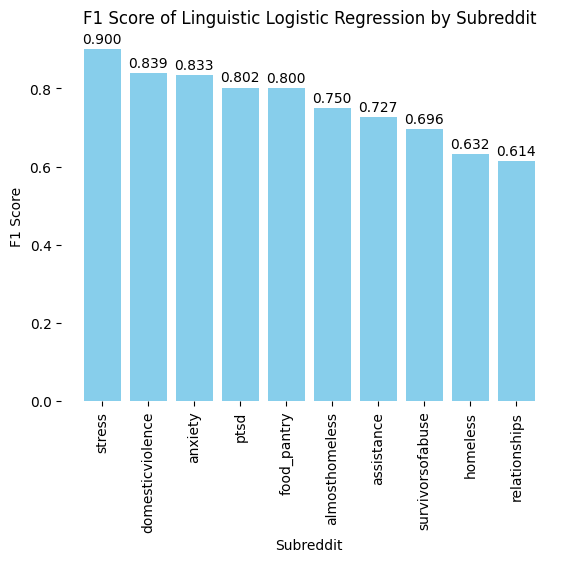

In [18]:
# F1 score by subreddit
subreddits = test_df['subreddit'].unique()
subreddit_f1_lf = pd.DataFrame(index=subreddits, columns=['F1 Score'])

for subreddit in subreddits:
    subreddit_mask = test_df['subreddit'] == subreddit
    subreddit_f1_lf.loc[subreddit, 'F1 Score'] = f1_score(y_test_lf[subreddit_mask], preds_lf[subreddit_mask])
subreddit_f1_lf = subreddit_f1_lf.sort_values(by='F1 Score', ascending=False)

# plot bar graph of F1 score by subreddit
bars = plt.bar(subreddit_f1_lf.index, subreddit_f1_lf['F1 Score'], color='skyblue')
plt.bar_label(bars, fmt='%.3f', padding=2)
plt.xticks(rotation=90)
plt.xlabel('Subreddit')
plt.ylabel('F1 Score')
plt.title('F1 Score of Linguistic Logistic Regression by Subreddit')
# remove borders
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

The model achieves the highest F1 scores in subreddits such as stress (0.9), domestic violence (0.84) and anxiety (0.83). A likely explanation is that these subreddits are emotion-focused, where the language signals of stress are clearer and more consistent, enabling the models to more easily distinguish stressed from non-stressed posts.

## Model 2: Logistic Regression with Term Frequency-Inverse Document Frequency (TF-IDF)

TF-IDF represents text based on word frequency patterns while assigning greater importance to informative terms and reducing the influence of common words. The TF-IDF model provides a data-driven representation of language. Logistic regression was chosen as it is computationally efficient and highly interpretable. The model allows direct examination of the individual words and phrases that influence predictions.

In [19]:
# import preprocessing libraries
import nltk
nltk.download("punkt_tab")
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/susanc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/susanc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
stop_words = stopwords.words('english')

def tfidf_tokenize(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words]
    return " ".join(filtered_tokens)

train_df["clean_text"] = train_df["text"].apply(tfidf_tokenize)
test_df["clean_text"] = test_df["text"].apply(tfidf_tokenize)

/var/folders/st/693__xjj7n3_d22nvb3bfr1r0000gn/T/ipykernel_74964/3285585167.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df["clean_text"] = train_df["text"].apply(tfidf_tokenize)
/var/folders/st/693__xjj7n3_d22nvb3bfr1r0000gn/T/ipykernel_74964/3285585167.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df["clean_text"] = test_df["text"].apply(tfidf_tokenize)


In [21]:
vectorizer_tfidf = TfidfVectorizer(stop_words=stop_words, max_features=10000, min_df=5, ngram_range=(1, 2))

X_train_tfidf = vectorizer_tfidf.fit_transform(train_df['clean_text'])
X_test_tfidf = vectorizer_tfidf.transform(test_df['clean_text'])

In [22]:
tfidf_model = LogisticRegression(max_iter=1000, random_state=42)
tfidf_model.fit(X_train_tfidf, train_df['label'])

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

### Evaluation

In [23]:
preds_tfidf = tfidf_model.predict(X_test_tfidf)

f1_tfidf = f1_score(test_df['label'], preds_tfidf)
print(f"Test F1 Score: {f1_tfidf:.4f}")
 
print("\nConfusion Matrix:")
print(confusion_matrix(test_df['label'], preds_tfidf))

Test F1 Score: 0.7448

Confusion Matrix:
[[228 118]
 [ 80 289]]


The Logistic Regression model using TF-IDF features achieved an F1 score of 0.7448. Though computationally efficient and effective at highlighting strong keyword indicators, TF-IDF lacks the ability to understand word context and sequential meaning.

### Analysis 3: Top Stress/Non-stress Indicators

In [24]:
feature_names = vectorizer_tfidf.get_feature_names_out()
coefficients = tfidf_model.coef_[0]

# top stress indicators
top_stress_idx = np.argsort(coefficients)[-20:]
print("Top stress-related words:")
print(feature_names[top_stress_idx])

# top non-stress indicators
top_nonstress_idx = np.argsort(coefficients)[:20]
print("\nTop non-stress words:")
print(feature_names[top_nonstress_idx])

Top stress-related words:
['days' 'getting' 'literally' 'stop' 'worried' 'anxious' 'hard' 'afraid'
 'past' 'sorry' 'need' 'hate' 'tell' 'know' 'fucking' 'scared' 'ca'
 'anxiety' 'even' 'feel']

Top non-stress words:
['url' 'met' 'would' 'thank' 'survey' 'free' 'share' 'great' 'others'
 'years' 'first' 'edit' 'together' 'food' 'good' 'bit' 'let know' 'older'
 'interested' 'helped']


Unlike the computed LIWC and sentiment features, TF-IDF uses individual words directly as predictors. The model learns which words increase or decrease the probability of a post being labelled as stress.

Key stress-indicating words include:
- Emotinal distress: worried, anxious, afraid, scared, anxiety, hate
- Psychological struggle: hard, stop, literally
- Self-expression: feel, know, tell, sorry
- Intensity markers: fucking

This suggests that the model detects stress primarily through direct emotional language and vocabulary.

Key non-stress indicators include:
- Social: thank, share, together, others
- Positive sentiment: great, good
- Information sharing: survey, url
- Engagement: interested, helped

This suggests that the absence of emotional distress language and presence of neutral discussion topics signal non-stress to the model.

The TF-IDF approach is simple, computationally efficient and highly interpretable. It provides clear linguistic markers of stress. However, it does not capture context or meaning of words, cannot understand sarcasm or implicit stress and cannot treat words dependently.

Therefore, compared to the liguistic features, TF-IDF captures surface-level emotional signals while the first model's feature representation detected deeper psychological markers.

## Model 3: Bidirectional Encoder Representations from Transformers (BERT)

The third and last method is BERT, a transformer-based model that can understand the meaning of ambiguous language in text by using surrounding text to establish context. BERT was selected because transformer-based models have demonstrated strong performance in natural language understanding tasks. By comparing BERT with simpler models, this study evaluates whether contextual understanding provides meaningful improvements in stress detection.

In [25]:
# import Hugging Face libraries
from datasets import Dataset
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, pipeline, Trainer, TrainingArguments

/Users/susanc/DSA4262/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
train_data, val_data = train_test_split(train_df, train_size=0.9,  random_state=42)

# convert 'text' and 'label' columns to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_data[['text', 'label']])
val_dataset = Dataset.from_pandas(val_data[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

A relatively small transformer model was used to reduce training time and computational cost. Larger transformer models, with more layers and parameters, may better capture contextual relationship and long-range dependencies in text. However, compared to the above classical methods, this improvement comes at substantial computational cost, limiting their practicality in low-resource or real-time settings.

In [26]:
# initialise a small BERT model to speed up training
bert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                            num_labels=2)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 2565.87it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [28]:
# tokenize datasets
def bert_tokenize(examples):
    return bert_tokenizer(examples["text"], padding="max_length", truncation=True, max_length=192, random_state=42)

tokenized_train = train_dataset.map(bert_tokenize, batched=True)
tokenized_val = val_dataset.map(bert_tokenize, batched=True)
tokenized_test = test_dataset.map(bert_tokenize, batched=True)

Map: 100%|██████████| 715/715 [00:00<00:00, 23132.38 examples/s]


In [29]:
# training arguments for Hugging Face Trainer
training_args = TrainingArguments(
        output_dir="./BERT_stress_classifier_results",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        seed=42,
    )

# initialize Trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=bert_tokenizer,
)

trainer.train()

/Users/susanc/DSA4262/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss
1,No log,0.460153
2,No log,0.453308
3,No log,0.518542


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]
/Users/susanc/DSA4262/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]
/Users/susanc/DSA4262/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=480, training_loss=0.3487301508585612, metrics={'train_runtime': 386.8641, 'train_samples_per_second': 19.805, 'train_steps_per_second': 1.241, 'total_flos': 380611953188352.0, 'train_loss': 0.3487301508585612, 'epoch': 3.0})

### Evaluation

In [30]:
# get predictions on test set
preds_bert = trainer.predict(tokenized_test)
pred_labels = np.argmax(preds_bert.predictions, axis=1)
true_labels = preds_bert.label_ids

f1_bert = f1_score(true_labels, pred_labels)
print(f"Test F1 Score: {f1_bert:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

/Users/susanc/DSA4262/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Test F1 Score: 0.8048

Confusion Matrix:
[[268  78]
 [ 68 301]]


The  BERT model achieved an F1 score of 0.8048, outperforming the traditional machine learning models. The self-attention mechanism in BERT allows it to understand the nuanced context of stress-related language better than TF-IDF or computed linguistic features.

In [31]:
# save the best BERT model
bert_model.save_pretrained("./BERT_stress_classifier")
bert_tokenizer.save_pretrained("./BERT_stress_classifier")

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


('./BERT_stress_classifier/tokenizer_config.json',
 './BERT_stress_classifier/tokenizer.json')

# Analysis 4: Where BERT was Confidently Wrong

In [32]:
# get misclassified indices
misclassified_indices = np.where(true_labels != pred_labels)[0]

print(f"Total number of misclassified posts: {len(misclassified_indices)} out of {len(true_labels)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(true_labels):.2%}")

# create a dataframe with misclassified examples
misclassified_df = pd.DataFrame({
    'text': [test_df['text'].tolist()[i] for i in misclassified_indices],
    'true_label': [true_labels[i] for i in misclassified_indices],
    'predicted_label': [pred_labels[i] for i in misclassified_indices],
    'model_confidence': [np.max(preds_bert.predictions[i]) for i in misclassified_indices],
    'label_confidence': [test_df['confidence'].tolist()[i] for i in misclassified_indices],
    'subreddit': [test_df['subreddit'].tolist()[i] for i in misclassified_indices]
})

# add label names for readability
label_map = {0: 'non-stress', 1: 'stress'}
misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
misclassified_df['predicted_label_name'] = misclassified_df['predicted_label'].map(label_map)

# sort by model confidence
misclassified_df = misclassified_df.sort_values('model_confidence', ascending=False)

print("\n=== Top 5 Misclassified Posts (by Model Confidence) ===")
for idx, row in misclassified_df.head().iterrows():
    print(f"\nText: {row['text']}")
    print(f"True: {row['true_label_name']} | Predicted: {row['predicted_label_name']} | Model Confidence: {row['model_confidence']:.3f} | Label Confidence: {row['label_confidence']:.3f} | Subreddit: {row['subreddit']}")

Total number of misclassified posts: 146 out of 715
Misclassification rate: 20.42%

=== Top 5 Misclassified Posts (by Model Confidence) ===

Text: We had 2 classes together, so we spent a few hours together most days working through problem sets. This next semester, I won't even have that. I'll probably be in more isolation this time around. Any tips are appreciated. Thanks!
True: stress | Predicted: non-stress | Model Confidence: 1.925 | Label Confidence: 0.667 | Subreddit: stress

Text: Maybe anyone with a history of abuse or trauma can tell me if there are particular things to be sensitive to here: I tried to be supportive but obviously failed in the end here. She's talking about wanting to divorce me. We're looking into couples therapy. I really appreciate any insight or advice. **TLDR**: Wife is working on an art piece that is important for her career in the arts non-profit world.
True: stress | Predicted: non-stress | Model Confidence: 1.872 | Label Confidence: 0.500 | Subreddit:

Analysis of the top misclassified examples reveals relatively low label confidence scores (0.5-0.67), indicating limited agreement among human annotators. Although the example texts describe stressful life events such as isolation and divorce, they do not use stong emotional keywords. The language is rather descriptive and polite, causing the model to struggle in detecting implicit stress.

We further examine the first example using SHapley Additive exPlanations (SHAP) to understand what words are affecting BERT's decision-making.

In [33]:
# import SHAP library
import shap

In [38]:
bert_model.config.id2label = {0: "non-stress", 1: "stress"}
bert_model.config.label2id = {"non-stress": 0, "stress": 1}

pipe = pipeline(
    "text-classification", 
    model=bert_model, 
    tokenizer=bert_tokenizer, 
    return_all_scores=True,
)

explainer = shap.Explainer(pipe)

def analyze_shap_values(df, idx):
    results = []
    
    text = df.iloc[idx]['text']
        
    # get SHAP values
    shap_values = explainer([text])
        
    print(f"Text: {text}")
    print(f"True: {df.iloc[idx]['true_label_name']}")
    print(f"Predicted: {df.iloc[idx]['predicted_label_name']}")
        
    # generate an HTML plot (which can be viewed in a browser or Jupyter notebook)
    html_plot = shap.plots.text(shap_values, display=False)
    with open('shap_explanation.html', 'w') as f:
        f.write(html_plot)
        
    # extract word contributions
    word_contributions = []
    tokens = shap_values[0].data
    contributions = shap_values[0].values
        
    for token, contrib in zip(tokens, contributions):
        # contribution[0] = non-stress, contribution[1] = stress
        word_contributions.append({
            'word': token,
            'stress_impact': contrib[1],
            'non_stress_impact': contrib[0],
            'net_impact': contrib[1] - contrib[0]
        })
        
    word_df = pd.DataFrame(word_contributions)
    # remove special tokens
    word_df = word_df[~word_df['word'].isin(['[CLS]', '[SEP]', '[PAD]'])]  
        
    print("\nTop 5 words pushing toward STRESS:")
    top_stress = word_df.nlargest(5, 'stress_impact')[['word', 'stress_impact']]
    print(top_stress.to_string(index=False))
        
    print("\nTop 5 words pushing toward NON-STRESS:")
    top_non_stress = word_df.nlargest(5, 'non_stress_impact')[['word', 'non_stress_impact']]
    print(top_non_stress.to_string(index=False))

# analyze misclassified example with highest model confidence
analyze_shap_values(misclassified_df, 0)

Text: We had 2 classes together, so we spent a few hours together most days working through problem sets. This next semester, I won't even have that. I'll probably be in more isolation this time around. Any tips are appreciated. Thanks!
True: stress
Predicted: non-stress

Top 5 words pushing toward STRESS:
    word  stress_impact
                    0.0
     We             0.0
    had             0.0
      2             0.0
classes             0.0

Top 5 words pushing toward NON-STRESS:
       word  non_stress_impact
appreciated           0.047425
       are            0.036152
      tips            0.022407
       Any            0.021563
     Thanks           0.017169


The SHAP visualisation shows that the most influential tokens in the post push the prediction towards the non-stress label. Words such as 'appreciated', 'tips' and 'together' have positive contributions to the non-stress class, reducing the predicted stress probability. In contrast, there are no strong positive contributions towards the stress class. Notably, the model did not pay attention to the word 'isolation'. The model failed to assign sufficient importance to more subtle and polite stress cues, leading to misclassification.

## Conclusion

While transformer models such as BERT achieve strong predictive performance, they are generally less interpretable than classical models like logistic regression with TF-IDF or linguistic features. In contrast to individual word coefficients, transformer models rely on high-dimensional contextual embeddings. Even with explanation tools such as SHAP, interpretations are approximate and assumptious. Therefore, while transformer models capture contextual nuance and achieve the best F1 score, their decision-making process is less transparent than the classical models with explicit feature weights.

## Appendix

The code for this notebook can be found in 'Assignment 2 - Predictive Modelling' folder on https://github.com/kahsuann/DSA4262. It should take less than 10 minutes to run the entire notebook.

## AI Declaration

I used GPT-5 to generate code for the BERT model and SHAP explainer. I am responsible for the content and quality of the submitted work.

## References

Turcan, E., & McKeown, K. (2019, November). Dreaddit: A reddit dataset for stress analysis in social media. In Proceedings of the tenth international workshop on health text mining and information analysis (LOUHI 2019) (pp. 97-107).